# Contexte
Le jeu vidéo est de nos jours l'industrie culturelle la plus lucrative, surpassant largement depuis plusieurs années le cinéma.
Cette 

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Lecture du fichier et nettoyage des données

In [3]:
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
taille_origine = len(df)
print("voici le nombre de données manquante par colonne du tableau")
#ceci est logique, le site internet metacritic a peu d'informations sur les jeux vidéos un peu datés
#supprimons les lignes ayant des données manquantes
df = df.dropna()
taille_sans_na=len(df) 
print(f"nous passons de {taille_origine} jeux à {taille_sans_na} jeux dans notre jeu de données en enlevant les données manquantes")


voici le nombre de données manquante par colonne du tableau
nous passons de 16719 jeux à 6825 jeux dans notre jeu de données en enlevant les données manquantes


### Enlever duplicata

In [4]:
print(df.loc[df.duplicated(subset=['Name'])])
#tous les jeux étant sortis sur plusieurs plateforme apparaissent avec cette requête

                                    Name Platform  Year_of_Release     Genre   
23                    Grand Theft Auto V     X360           2013.0    Action  \
35            Call of Duty: Black Ops II     X360           2012.0   Shooter   
37        Call of Duty: Modern Warfare 3      PS3           2011.0   Shooter   
41               Call of Duty: Black Ops      PS3           2010.0   Shooter   
42                    Grand Theft Auto V      PS4           2014.0    Action   
...                                  ...      ...              ...       ...   
16601        Saints Row: Gat out of Hell     XOne           2015.0    Action   
16618           Legacy of Kain: Defiance       PC           2003.0    Action   
16634           Sébastien Loeb Rally Evo     XOne           2016.0    Racing   
16677     Mortal Kombat: Deadly Alliance      GBA           2002.0  Fighting   
16696  Metal Gear Solid V: Ground Zeroes       PC           2014.0    Action   

                          Publisher  NA

In [5]:
df.loc[df.duplicated(subset=['Name','Platform'])]


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,Electronic Arts,1.0,0.13,0.02,0.10,1.25,83.0,54.0,8.5,134.0,EA Canada,T
11716,Need for Speed: Most Wanted,PC,2012.0,Racing,Electronic Arts,0.0,0.06,0.00,0.02,0.08,82.0,19.0,8.5,525.0,Black Box,T
16233,Madden NFL 13,PS3,2012.0,Sports,Electronic Arts,0.0,0.01,0.00,0.00,0.01,83.0,22.0,5.5,101.0,EA Tiburon,E


In [6]:
df[df["Name"]=="Need for Speed: Most Wanted"]
#Need for speed most wanted a eu un remake en 2012, mais sinon pas de données dupliquées

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,Electronic Arts,2.03,1.79,0.08,0.47,4.37,82.0,36.0,9.1,137.0,EA Canada,T
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,Electronic Arts,0.62,0.78,0.01,0.15,1.56,83.0,54.0,8.5,134.0,EA Canada,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,Electronic Arts,1.00,0.13,0.02,0.10,1.25,83.0,54.0,8.5,134.0,EA Canada,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,Electronic Arts,0.53,0.46,0.00,0.05,1.04,83.0,32.0,8.8,29.0,EA Canada,T
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,Electronic Arts,0.43,0.11,0.00,0.02,0.56,80.0,18.0,9.1,22.0,EA Canada,T
5973,Need for Speed: Most Wanted,PC,2005.0,Racing,Electronic Arts,0.02,0.23,0.00,0.04,0.29,82.0,19.0,8.5,525.0,Black Box,T
6411,Need for Speed: Most Wanted,DS,2005.0,Racing,Electronic Arts,0.24,0.01,0.00,0.02,0.27,45.0,4.0,6.1,22.0,EA Canada,E
11716,Need for Speed: Most Wanted,PC,2012.0,Racing,Electronic Arts,0.00,0.06,0.00,0.02,0.08,82.0,19.0,8.5,525.0,Black Box,T


In [7]:
df[df["Name"]=="Madden NFL 13"]
#On a deux entrées pour Madden NFL 13 sur la PS3, supprimons celle qui n'a aucune vente
df.drop(df.loc[(df['NA_Sales'] == 0) & (df["Name"] == "Madden NFL 13")].index, inplace = True)

In [8]:
df.dtypes
df[["Name","Platform","Genre","Publisher","Developer","Rating"]] = df[["Name","Platform","Genre","Publisher","Developer","Rating"]].astype(str)
df["User_Score"] = df["User_Score"].astype(float)
df["Year_of_Release"] = df["Year_of_Release"].astype(int)
df.dtypes

Name                object
Platform            object
Year_of_Release      int32
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Developer           object
Rating              object
dtype: object

<Axes: >

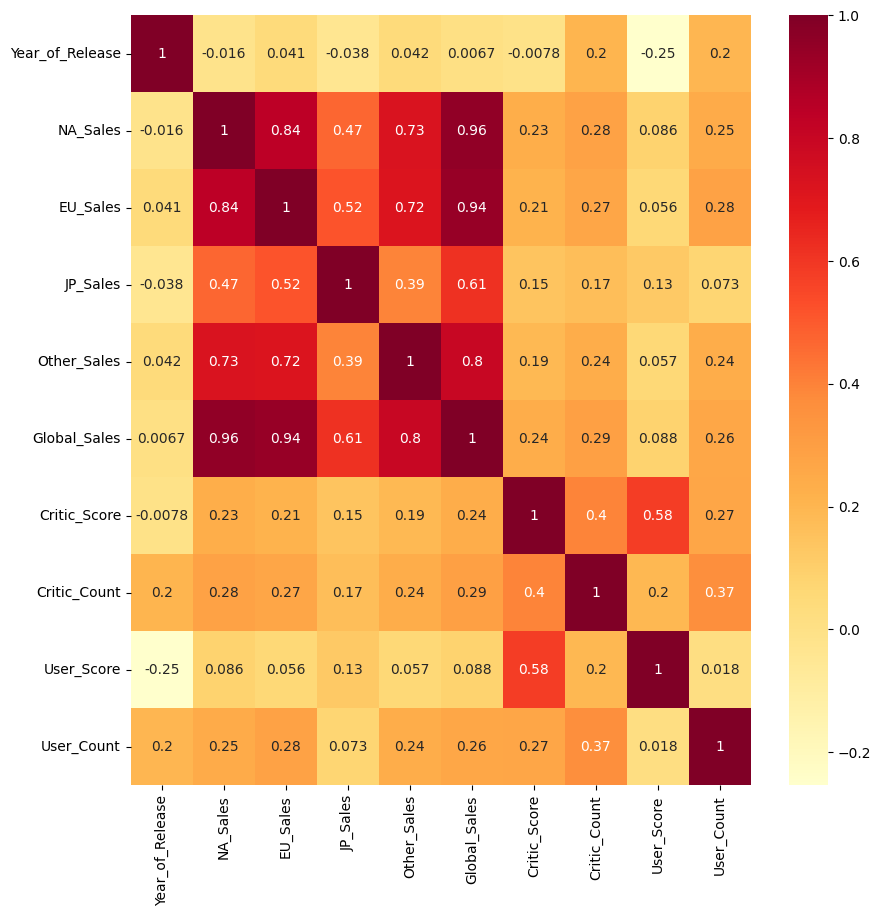

In [9]:
fig = plt.figure(figsize=(10,10))
corr=df.corr(numeric_only=True)
sns.heatmap(corr,annot=True,  cmap='YlOrRd')
#corrélation entre les variables

On observe sans surprise que les colonnes de ventes (ventes aux US, en Europe, au japon) sont très corrélées entre elles (le Japon un peu moins car ce marché est réputé pour avoir ses particularités) nous nous interesserons uniquement aux ventes globales dans notre modèle, et donc **supprimerons les autres valeurs de vente**

User_Score et Critic_Score sont aussi assez corrélées, un bon jeu sera souvent apprécié par les critique professionnels et par les joueurs normaux en même temps

In [ ]:
#On supprime du jeu de données les ventes par régions. On supprime aussi le nom des jeux qui est une donnée inutisable
df.drop(['Global_Sales','NA_Sales','EU_Sales','JP_Sales',"Other_Sales","Name"], axis=1,inplace=True)

In [10]:
# Somme cumulative des ventes par année
sales_by_publisher = df.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False)
cumulative_sales = sales_by_publisher.cumsum()
total_sales = cumulative_sales.max()

# Determine how many publishers represent 90% of sales
top_publishers = (cumulative_sales / total_sales).lt(0.9).sum() + 1

print(f'{top_publishers} éditeurs represent 90% des ventes')

#Même chose mais avec les developpeurs
sales_by_dev = df.groupby('Developer')['Global_Sales'].sum().sort_values(ascending=False)
cumulative_sales_dev = sales_by_dev.cumsum()
total_sales_dev = cumulative_sales.max()

top_dev = (cumulative_sales_dev / total_sales_dev).lt(0.8).sum() + 1
print(f'{top_dev} devs representent 80% des ventes')

20 éditeurs represent 90% des ventes
178 devs representent 80% of sales


On cherche à réduire la dimension de notre réponse en mettant les éditeurs et developpeurs vendant le moins dans la catégorie "autres

In [15]:
df['Developer'] = df['Developer'].apply(lambda s: s if s not in sales_by_dev[top_dev:] else 'Autres')
df['Publisher'] = df['Publisher'].apply(lambda s: s if s not in sales_by_publisher[top_publishers:] else 'Autres')

In [12]:
ct = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(sparse=False), ["Platform", "Developer","Genre","Rating","Publisher"]),
    ],
    remainder="passthrough",).set_output(transform="pandas")
df_ohe=ct.fit_transform(df)


c:\Users\amine\OneDrive\Bureau\IODAA\venv_python\new_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
# Prepare the data
X = df_ohe.drop(['remainder__Global_Sales','remainder__NA_Sales','remainder__EU_Sales','remainder__JP_Sales',"remainder__Other_Sales"], axis=1)

X=df_ohe.drop('remainder__Name', axis=1)
y = df_ohe['remainder__Global_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create models
linear_regression = LinearRegression()
ridge = Ridge()
lasso = Lasso()

# Set up hyperparameter tuning for Ridge and Lasso models
param_grid_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5)
lasso_cv = GridSearchCV(lasso, param_grid_lasso, cv=5)

# Create a list of models and their names
models = [
    ('Linear Regression', linear_regression),
    ('Ridge Regression', ridge_cv),
    ('Lasso Regression', lasso_cv)
]

# Train and evaluate models
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'{model_name}:')
    print(f'  Mean Absolute Error: {mae:.4f}')
    print(f'  Mean Squared Error: {mse:.4f}')
    print(f'  R² Score: {r2:.4f}')
    
    if hasattr(model, 'best_params_'):
        print(f'  Best Parameters: {model.best_params_}')
    
    print()

KeyError: "['remainder__NA_Sales', 'remainder__EU_Sales', 'remainder__JP_Sales', 'remainder__Other_Sales'] not found in axis"

In [ ]:
df_ohe=df_ohe.drop('remainder__Name', axis=1)


In [ ]:

corr_matrix = df_ohe.corr()
# Select the top k features with the highest correlation with the target variable
k = 10
top_features = corr_matrix.nlargest(k, 'remainder__Global_Sales')['remainder__Global_Sales'].index

# Perform Recursive Feature Elimination
n_features_to_select = 10
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)
selector = selector.fit(X, y)

# Get the selected features
selected_features = X.columns[selector.support_]

print("Top correlated features:", top_features)
print("Features selected by RFE:", selected_features)

Top correlated features: Index(['remainder__Global_Sales', 'ohe__Developer_Nintendo',
       'remainder__Critic_Count', 'remainder__User_Count',
       'remainder__Critic_Score', 'ohe__Publisher_Nintendo',
       'ohe__Developer_Rockstar North', 'ohe__Developer_Polyphony Digital',
       'ohe__Developer_Good Science Studio', 'ohe__Developer_Infinity Ward'],
      dtype='object')
Features selected by RFE: Index(['remainder__Year_of_Release', 'remainder__NA_Sales',
       'remainder__EU_Sales', 'remainder__JP_Sales', 'remainder__Other_Sales',
       'remainder__Global_Sales', 'remainder__Critic_Score',
       'remainder__Critic_Count', 'remainder__User_Score',
       'remainder__User_Count'],
      dtype='object')
